In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

plt.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor()) # original images are in PIL form so we convert them to tensor
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

In [ ]:
len(dataset)

60000

image.shape torch.Size([1, 28, 28])
5
Permuted -  torch.Size([28, 28, 1])


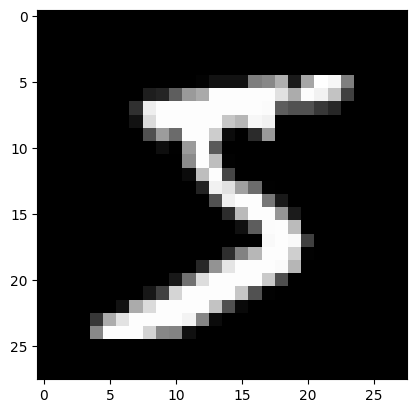

In [ ]:
image, label = dataset[0]
print('image.shape', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray') # permute - change the shape as plt.imshow wants color channel at the end
print(label)
print('Permuted - ', image.permute(1,2,0).shape)

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size]) # split the dataset randomly
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size = 128

# Defining Data Loaders as gradient Descent needs data in batches

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

# num_workers - which denotes the number of processes that generate batches in parallel
# pin memory - allocate memory on RAM to make reading from / writing to RAM to GPU/CPU faster

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


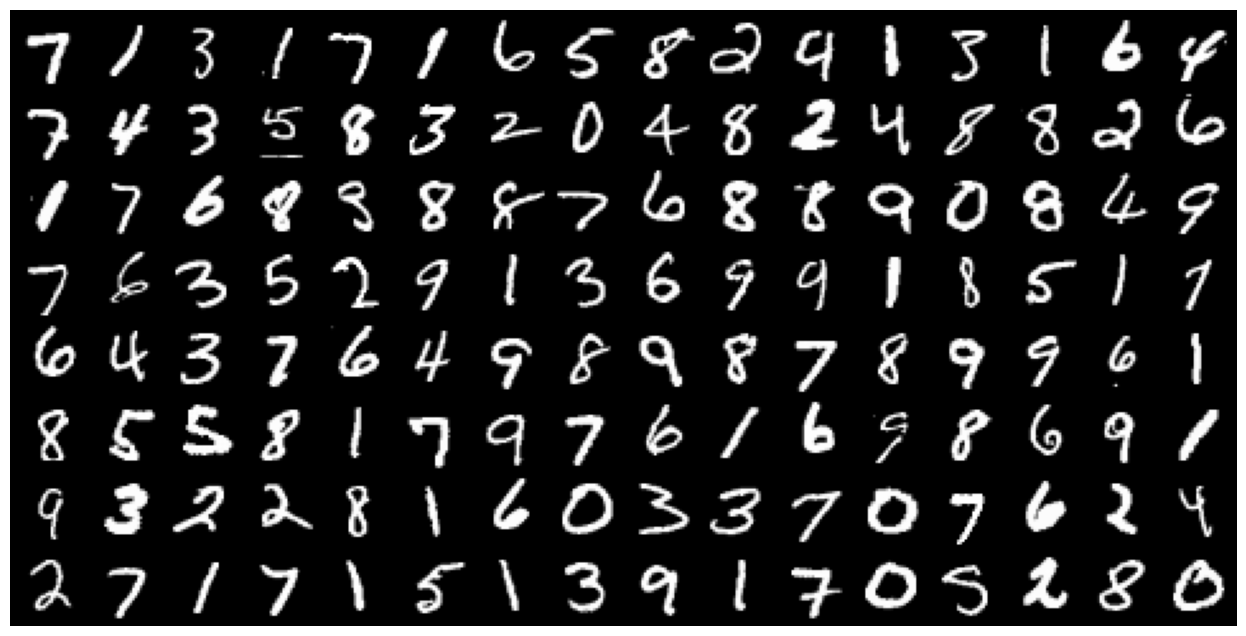

In [ ]:
for images, _ in train_loader:
  plt.figure(figsize=(16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

# make grid is used to arrange data in a grid

In [ ]:
# input_size = inputs[-1]
# hidden_size = 32

# layer1 = nn.Linear(input_size, hidden_size)
# layer1_outputs = layer1(inputs)
# relu_outputs = F.relu(layer1_outputs)

# output_size = 10
# layer2 = nn.Linear(hidden_size, output_size)
# layer2_outputs = layer2(relu_outputs)

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
class MnistModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    # hidden layer
    self.linear1 = nn.Linear(input_size, hidden_size)

    # output layer
    self.linear2 = nn.Linear(hidden_size, output_size)


  def forward(self, xb):
    # Flatten the tensor
    xb = xb.view(xb.size(0), -1)

    # Get intermidiete outputs using hidden layer
    out = self.linear1(xb)

    # Apply the activation function
    out = F.relu(out)

    # Get predictions
    out = self.linear2(out)

    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
model = MnistModel(784, 32, 10)

In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# use the 'to' method to transfer data or model from CPU to a GPU

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    # take the data loader and device
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr) # model.parameters() has all the weight matrices
  for epoch in range(epochs):
    # Training
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [ ]:
model = MnistModel(input_size=784, hidden_size=32, output_size=10)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.311469316482544, 'val_acc': 0.12035205960273743}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2795, val_acc: 0.9184
Epoch [1], val_loss: 0.1793, val_acc: 0.9497
Epoch [2], val_loss: 0.1643, val_acc: 0.9527
Epoch [3], val_loss: 0.1679, val_acc: 0.9522
Epoch [4], val_loss: 0.1350, val_acc: 0.9611


Text(0.5, 1.0, 'Loss vs Epoch')

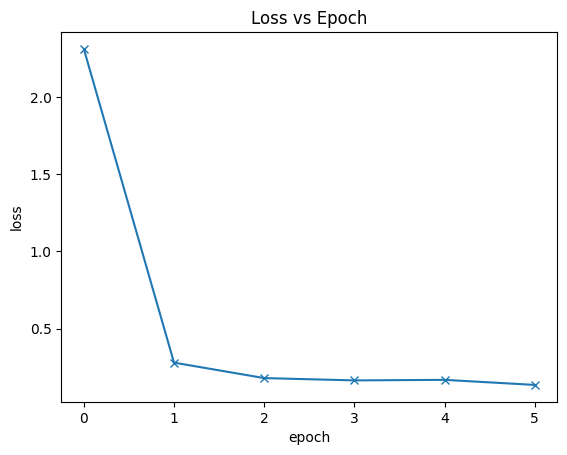

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epoch')

In [ ]:
 def predict(img, model):
  xb = to_device(img.unsqueeze(0), device) # convert image tensor to a batch of image tensor
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 7 , Predicted: 7


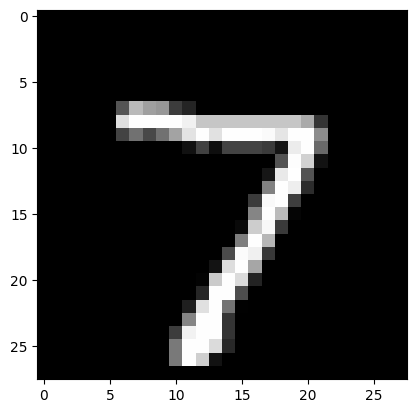

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1,2,0), cmap='gray')
print('Label:', label, ', Predicted:', predict(img, model))

Label: 9 , Predicted: 9


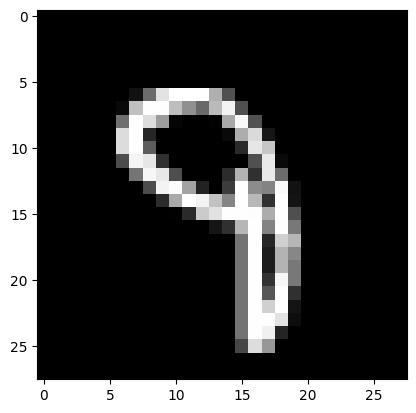

In [ ]:
img, label = test_dataset[193]
plt.imshow(img.permute(1,2,0), cmap='gray')
print('Label:', label, ', Predicted:', predict(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.12332828342914581, 'val_acc': 0.961621105670929}